# 1. Analyse exploratoire.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mytools as mt

### 1.1 CRÉATION DU DATASET POUR LA SÉGMENTATION DES CLIENTS.

Il y a quelques années, mon prédecesseur a segmenté la base de données en utilisant une approche RFM (Récence, Fréquence et Montant), c'est à dire à l'aide des trois features suvantes :
- Date de première commande (Récence ou ancienneté) ;
- Fréquence des commandes ;
- Montant des commandes.

Nous allons enrichir les données et réaliser une nouvelle segmentation avec les trois features supplémentaires suivantes :
- Le montant moyen des livraisons ;
- Le retard moyen des commandes ;
- Le score moyen (niveau de satisfaction) ;

À noter que le *montant des commandes* que nous allons inclure dans notre dataset n'inclus pas les frais de livraison.

In [2]:
%load_ext sql
%sql sqlite:///olist.db

Nous allons donc créer un tableau ou chaque ligne représente un client unique et qui contient les six features précédentes (avec le nombre de commandes plutôt que la fréquence) :

In [3]:
data = %sql   SELECT o.customer_id AS identifiant_client,\
                     max(o.order_purchase_timestamp) AS date_derniere_commande,\
                     count(o.order_id) AS nombre_de_commandes,\
                     sum(i.order_item_id*i.price)/sum(i.order_item_id) AS montant_moyen,\
                     avg(i.freight_value) AS montant_moyen_livraison,\
                     avg(o.order_delivered_customer_date - o.order_estimated_delivery_date) AS retard_moyen,\
                     avg(r.review_score) AS score_moyen\
                FROM orders o\
                JOIN order_items i ON o.order_id = i.order_id\
                JOIN order_reviews r ON o.order_id = r.order_id\
                WHERE order_status = 'delivered'\
                GROUP BY o.customer_id;

 * sqlite:///olist.db
Done.


In [4]:
data = pd.DataFrame(data)
data.head()

,identifiant_client,date_derniere_commande,nombre_de_commandes,montant_moyen,montant_moyen_livraison,retard_moyen,score_moyen
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,1,89.80,24.94,0.0,1.0
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1,54.90,12.51,0.0,4.0
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,1,179.99,15.43,0.0,5.0
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,1,149.90,29.45,0.0,5.0
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,1,93.00,14.01,0.0,4.0


In [5]:
data.set_index('identifiant_client', inplace=True)
data.head()

,date_derniere_commande,nombre_de_commandes,montant_moyen,montant_moyen_livraison,retard_moyen,score_moyen
identifiant_client,,,,,,
00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,1,89.80,24.94,0.0,1.0
000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,1,54.90,12.51,0.0,4.0
0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,1,179.99,15.43,0.0,5.0
0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,1,149.90,29.45,0.0,5.0
000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,1,93.00,14.01,0.0,4.0


In [6]:
data.shape

(95832, 6)

### 1.2 OUTLIERS.

In [7]:
mt.stats(data)

,count,mean,std,min,25%,50%,75%,max
nombre_de_commandes,95832.0,1.148,0.551,1.00,1.00,1.00,1.00,22.00
montant_moyen,95832.0,125.030,188.302,0.85,41.90,79.00,139.90,6735.00
montant_moyen_livraison,95832.0,20.141,15.674,0.00,13.37,16.35,21.15,409.68
retard_moyen,95824.0,-0.023,0.170,-1.00,0.00,0.00,0.00,1.00
score_moyen,95832.0,4.156,1.284,1.00,4.00,5.00,5.00,5.00


Le dataset ne semble pas contenir de valeurs aberrantes. Analysons maintenant les distributions des features :

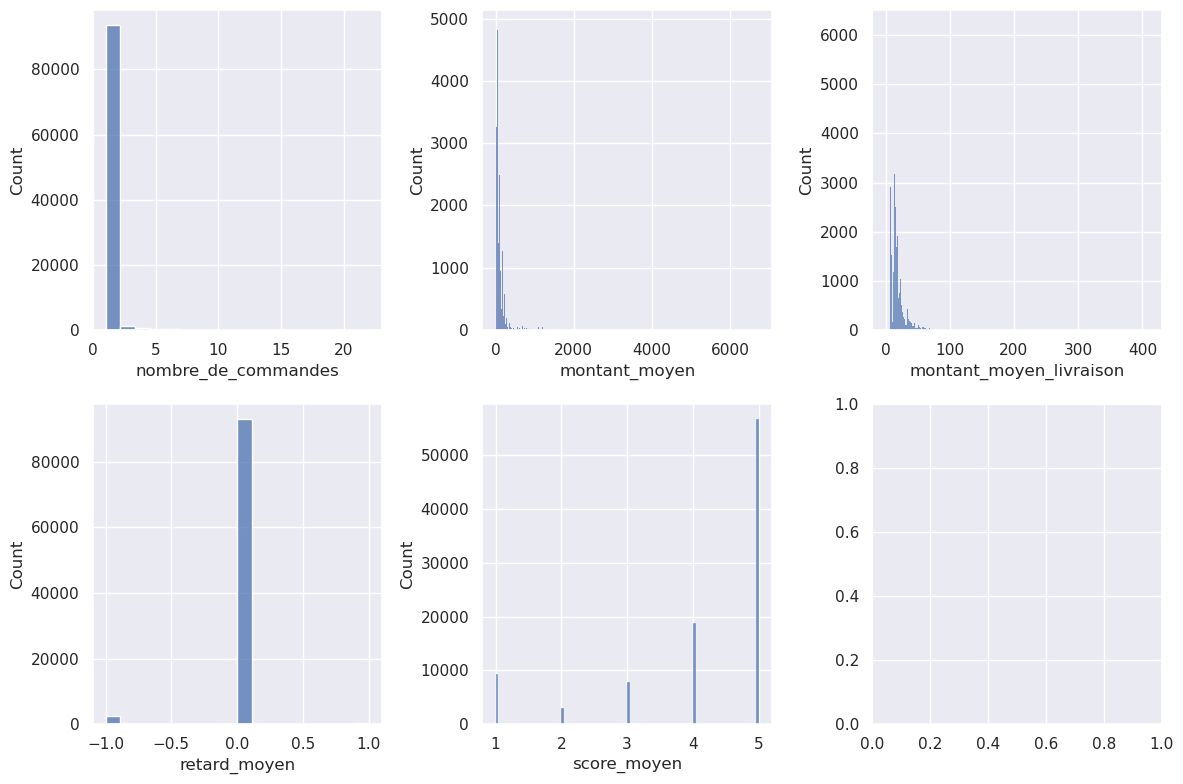

In [8]:
sns.set(style='darkgrid')
features = mt.stats(data).index
fig, axe = plt.subplots(2,3, figsize=(12,8))
axe = axe.flatten()
for i, feature in enumerate(features):
    sns.histplot(x=feature, data=data, ax=axe[i])
plt.tight_layout()
plt.show()

On observe que les features **nombre_de_commandes**, **montant_moyen** et **montant_moyen_livraison** ont un *skewness* et une amplitude élevés. Nous allons les passer au log afin de normaliser leurs distributions :

In [9]:
features = ['nombre_de_commandes', 'montant_moyen', 'montant_moyen_livraison']
data[features] = np.log10(data[features]+1)

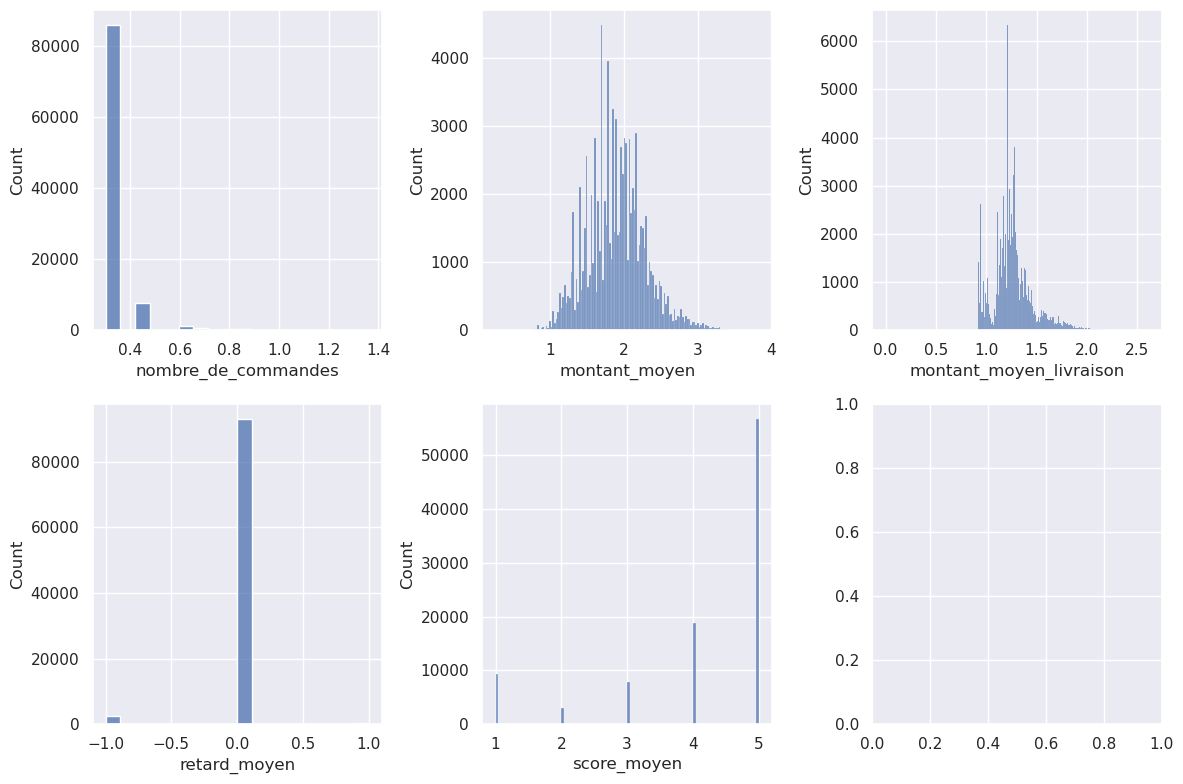

In [10]:
features = mt.stats(data).index
fig, axe = plt.subplots(2,3, figsize=(12,8))
axe = axe.flatten()
for i, feature in enumerate(features):
    sns.histplot(x=feature, data=data, ax=axe[i])
plt.tight_layout()
plt.show()

### 1.3 VALEURS MANQUANTES.

In [11]:
mt.valeurs_manquantes(data)

,effectif,taux
retard_moyen,8,0.0


La feature *retard_moyen* contient 8 valeurs manquantes. Regardons de plus près quels sont les clients concernés :

In [12]:
data[data.retard_moyen.isna()]

,date_derniere_commande,nombre_de_commandes,montant_moyen,montant_moyen_livraison,retard_moyen,score_moyen
identifiant_client,,,,,,
28c37425f1127d887d7337f284080a0f,2018-06-27 16:09:12,0.30103,1.671173,1.003029,NaN,5.0
29f0540231702fda0cfdee0a310f11aa,2018-07-01 17:05:11,0.30103,2.146128,1.302547,NaN,5.0
4f1d63d35fb7c8999853b2699f5c7649,2018-07-01 21:14:02,0.30103,2.278731,1.220892,NaN,5.0
5e89028e024b381dc84a13a3570decb4,2018-06-20 06:58:43,0.30103,2.518514,1.418964,NaN,5.0
cfda40ca8dd0a5d486a9635b611b398a,2018-07-01 22:05:55,0.30103,2.146128,1.302547,NaN,5.0
dd1b84a7286eb4524d52af4256c0ba24,2018-06-08 12:09:39,0.30103,2.049179,1.005609,NaN,1.0
e08caf668d499a6d643dafd7c5cc498a,2017-05-25 23:22:43,0.30103,2.255273,1.204120,NaN,5.0
ec05a6d8558c6455f0cbbd8a420ad34f,2017-11-28 17:44:07,0.30103,2.072985,1.267875,NaN,5.0


Nous allons chercher dans la base de données SQL les clients dont le statut des commandes est 'delivered' et dont la date de livraison est inconnue :

In [13]:
%%sql

SELECT DISTINCT customer_id 
FROM orders 
WHERE order_status = 'delivered'
      AND order_delivered_customer_date IS NULL;

 * sqlite:///olist.db
Done.


customer_id
ec05a6d8558c6455f0cbbd8a420ad34f
5e89028e024b381dc84a13a3570decb4
29f0540231702fda0cfdee0a310f11aa
cfda40ca8dd0a5d486a9635b611b398a
4f1d63d35fb7c8999853b2699f5c7649
e08caf668d499a6d643dafd7c5cc498a
dd1b84a7286eb4524d52af4256c0ba24
28c37425f1127d887d7337f284080a0f


On retrouve nos 8 clients. Nous allons imputer ces valeurs manquantes par la médiane de la feature *retard_moyen* :

In [14]:
data.loc[data.retard_moyen.isna(), 'retard_moyen'] = data.retard_moyen.median()

In [15]:
mt.valeurs_manquantes(data)

,effectif,taux


Il n'y a plus de valeurs manquantes ! Il ne nous reste plus qu'à traiter notre feature temporelle *date_premiere_commande*.

### 1.4 TRAITEMENT DE LA FEATURE *DATE_PREMIERE_COMMANDE*.

In [16]:
data.dtypes

date_derniere_commande      object
nombre_de_commandes        float64
montant_moyen              float64
montant_moyen_livraison    float64
retard_moyen               float64
score_moyen                float64
dtype: object

La feature **date_premiere_commande** est une variable de temps, donc nous allons la convertir en variable temporelle :

In [19]:
data.date_derniere_commande = pd.to_datetime(data.date_derniere_commande)
data.dtypes

date_derniere_commande     datetime64[ns]
nombre_de_commandes               float64
montant_moyen                     float64
montant_moyen_livraison           float64
retard_moyen                      float64
score_moyen                       float64
dtype: object

In [21]:
derniere_date = data.date_derniere_commande.max()
data['recence'] = derniere_date - data.date_derniere_commande
data.recence = data.recence.dt.days
data.head()

,date_derniere_commande,nombre_de_commandes,montant_moyen,montant_moyen_livraison,retard_moyen,score_moyen,recence
identifiant_client,,,,,,,
00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,0.30103,1.958086,1.413970,0.0,1.0,287
000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,0.30103,1.747412,1.130655,0.0,4.0,409
0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,0.30103,2.257655,1.215638,0.0,5.0,547
0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,0.30103,2.178689,1.483587,0.0,5.0,378
000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,0.30103,1.973128,1.176381,0.0,4.0,149


In [ ]:
data.drop(columns='date_derniere_commande', inplace=True)

On peut maintenant visualiser les distributions de toutes les features :

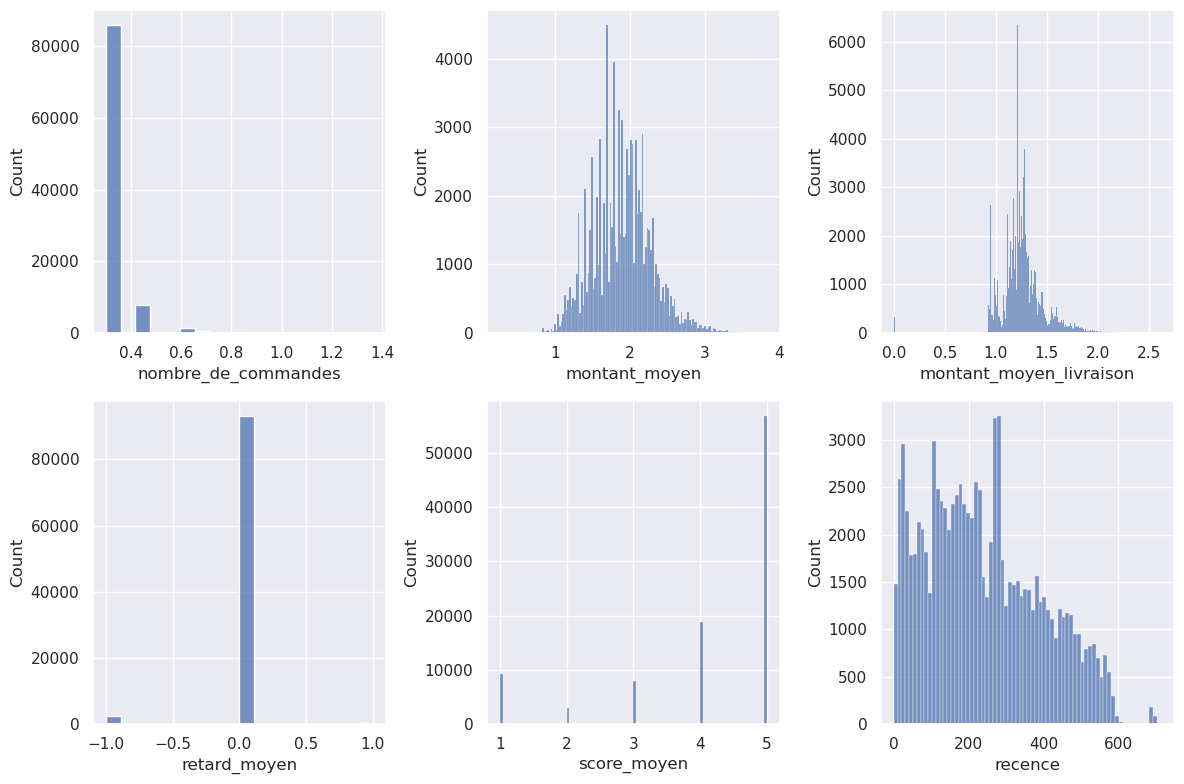

In [25]:
features = data.columns
fig, axe = plt.subplots(2,3, figsize=(12,8))
axe = axe.flatten()
for i, feature in enumerate(features):
    sns.histplot(x=feature, data=data, ax=axe[i])
plt.tight_layout()
plt.show()

On exporte les données dans un fichier csv :

In [26]:
data.to_csv('donnees_pour_segmentation.csv')